In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

from utils.metrics import *

from utils.decoders import KalmanFilterDecoder

In [30]:
import hdf5storage

fp = '/home/jd/Neural_Decoding-master/dataset/indy_20161005_06.mat'

matdata = hdf5storage.loadmat(fp)
spike_arr = matdata['spikes']
cur_pos= matdata['cursor_pos']
tar_pos= matdata['target_pos']
time_stamp = matdata['t'].squeeze(1)

In [31]:
cur_pos_2d = np.array([cur_pos[:, 0], cur_pos[:, 1]]).T
spike_raw = spike_arr[:, 0]

In [32]:
import math
# 以100毫秒作为一个bin,即25个记录点
bin_size = 25
bin_num = math.floor(time_stamp.shape[0] / bin_size)

spike_bin = np.array(np.zeros([bin_num, 96]))

for index_channel in range(0, 96):
    t = 0
    for i in spike_raw[index_channel]:
        if i >= time_stamp[0]:
            while t < time_stamp.shape[0] - bin_size and time_stamp[t] < i:
                t = t + 1
            if t < time_stamp.shape[0] :
                index_bin = math.floor(t / bin_size)
                spike_bin[index_bin][index_channel] = spike_bin[index_bin][index_channel] + 1

In [33]:
# 43号轨道有问题
spike_bin_raw = spike_bin[:, [not np.all(spike_bin[:, i] == 0) for i in range(spike_bin.shape[1])]]
print(spike_bin_raw.shape)
#spike_bin_nonzero = spike_bin_raw
spike_bin_nonzero = np.concatenate((spike_bin_raw[:, 0:43], spike_bin_raw[:, 44:85]), axis=1)
print(spike_bin_nonzero.shape)

(3740, 85)
(3740, 84)


In [34]:
vels_binned = []
for i in range(0, time_stamp.shape[0]-bin_size, bin_size):
    dx = cur_pos_2d[i + bin_size][0] - cur_pos_2d[i][0]
    dy = cur_pos_2d[i + bin_size][1] - cur_pos_2d[i][1]
    dt = bin_size * 0.004
    vx = dx/dt
    vy = dy/dt
    vels_binned.append([vx, vy])

vels_binned = np.array(vels_binned)

vels_binned = vels_binned[0:3000]
neural_data = spike_bin_nonzero[0:3000]
X_kf = neural_data

pos_binned=np.zeros(vels_binned.shape)
pos_binned[0,:]=0
for i in range(pos_binned.shape[0]-1): 
    pos_binned[i+1,0]=pos_binned[i,0]+vels_binned[i,0]*.1
    pos_binned[i+1,1]=pos_binned[i,1]+vels_binned[i,1]*.1
   
temp=np.diff(vels_binned,axis=0)
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0)

In [35]:
y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)
print(y_kf.shape)

(3000, 6)


In [36]:

lag = 0
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int32(np.round(training_range[0]*num_examples_kf))+1,np.int32(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int32(np.round(testing_range[0]*num_examples_kf))+1,np.int32(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int32(np.round(valid_range[0]*num_examples_kf))+1,np.int32(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

In [37]:
#Declare model
model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2 of [Vx, Vy]:', R2_kf[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2 of [Vx, Vy]:',rho_kf[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

R2 of [Vx, Vy]: [0.45521598 0.37747433]
rho2 of [Vx, Vy]: [0.46131834 0.38070332]


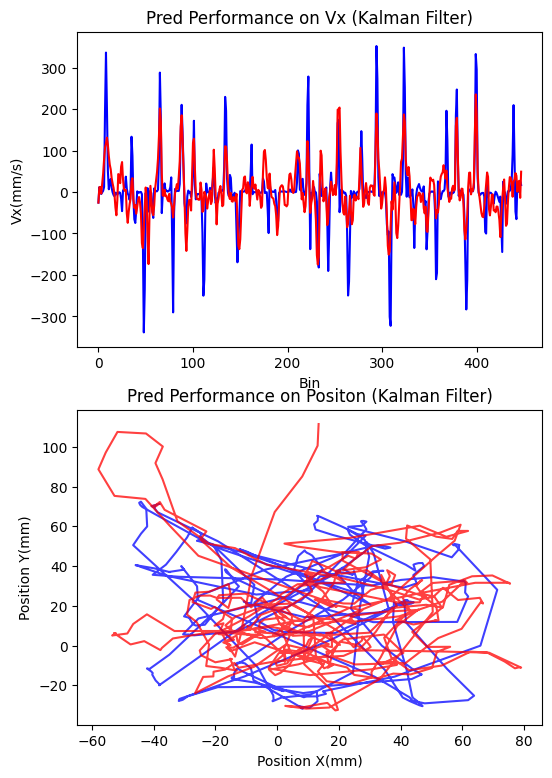

In [38]:
plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.title('Pred Performance on Vx (Kalman Filter)')
plt.xlabel('Bin')
plt.ylabel('Vx(mm/s)')
plt.plot(y_kf_valid[:450,2]+y_kf_train_mean[2],'b')
plt.plot(y_valid_predicted_kf[:450,2]+y_kf_train_mean[2],'r')
plt.subplot(212)
plt.title('Pred Performance on Positon (Kalman Filter)')
plt.xlabel('Position X(mm)')
plt.ylabel('Position Y(mm)')
plt.plot(y_kf_valid[:450,0]+y_kf_train_mean[0],y_kf_valid[:450,1]+y_kf_train_mean[1], 'b', alpha = 0.75)
plt.plot(y_valid_predicted_kf[:450,0]+y_kf_train_mean[0],y_valid_predicted_kf[:450,1]+y_kf_train_mean[1],'r', alpha = 0.75)

R2 of [Vx, Vy]: [0.15406853 0.11182512]


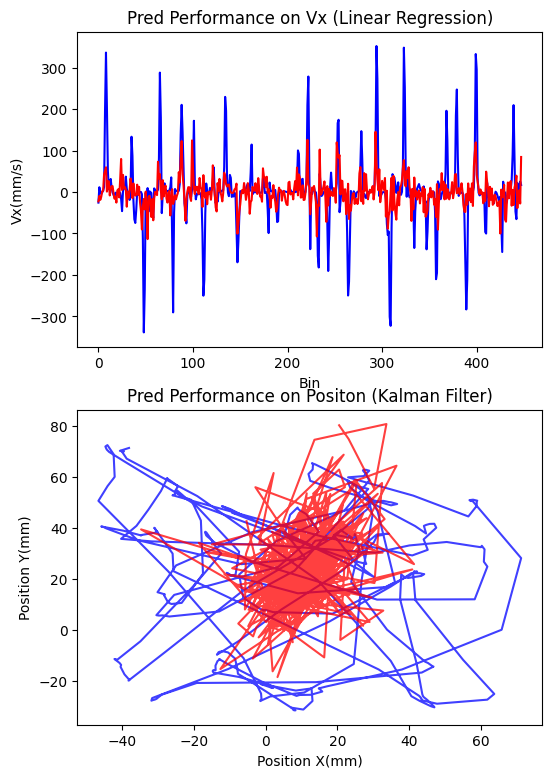

In [41]:
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()
model_linear.fit(X_kf_train, y_kf_train)
y_valid_predicted_linear= model_linear.predict(X_kf_valid)

R2_kf=get_R2(y_kf_valid,y_valid_predicted_linear)
print('R2 of [Vx, Vy]:', R2_kf[2:4]) 

plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.title('Pred Performance on Vx (Linear Regression)')
plt.xlabel('Bin')
plt.ylabel('Vx(mm/s)')
plt.plot(y_kf_valid[:450,2]+y_kf_train_mean[2],'b')
plt.plot(y_valid_predicted_linear[:450,2]+y_kf_train_mean[2],'r')
plt.subplot(212)
plt.title('Pred Performance on Positon (Linear Regression)')
plt.xlabel('Position X(mm)')
plt.ylabel('Position Y(mm)')
plt.plot(y_kf_valid[:450,0]+y_kf_train_mean[0],y_kf_valid[:450,1]+y_kf_train_mean[1], 'b', alpha = 0.75)
plt.plot(y_valid_predicted_linear[:450,0]+y_kf_train_mean[0],y_valid_predicted_linear[:450,1]+y_kf_train_mean[1],'r', alpha = 0.75)

R2 of [Vx, Vy]: [0.15956585 0.11761085]


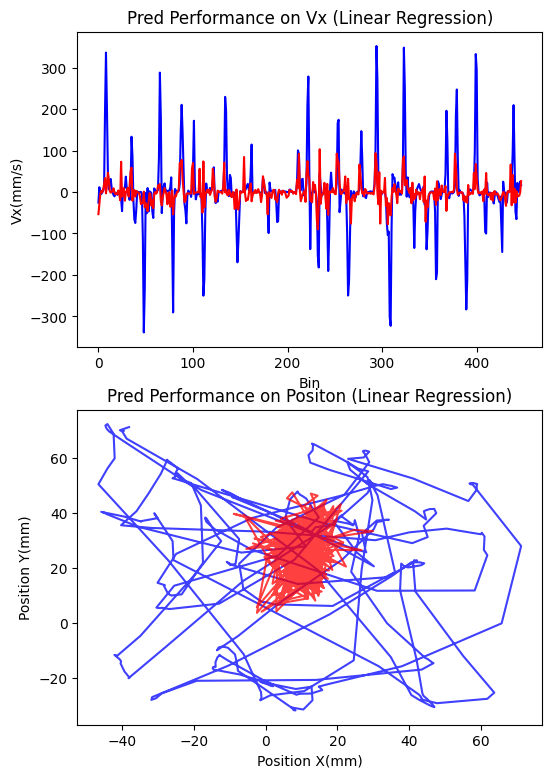

In [42]:
from sklearn.ensemble import ExtraTreesRegressor

model_randtree = ExtraTreesRegressor(n_estimators=600, max_depth=20, min_samples_leaf=2)
model_randtree.fit(X_kf_train, y_kf_train)
y_valid_predicted_randtree= model_randtree.predict(X_kf_valid)

R2_kf=get_R2(y_kf_valid,y_valid_predicted_randtree)
print('R2 of [Vx, Vy]:', R2_kf[2:4]) 

plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.title('Pred Performance on Vx (Random Forest)')
plt.xlabel('Bin')
plt.ylabel('Vx(mm/s)')
plt.plot(y_kf_valid[:450,2]+y_kf_train_mean[2],'b')
plt.plot(y_valid_predicted_randtree[:450,2]+y_kf_train_mean[2],'r')
plt.subplot(212)
plt.title('Pred Performance on Positon (Random Forest)')
plt.xlabel('Position X(mm)')
plt.ylabel('Position Y(mm)')
plt.plot(y_kf_valid[:450,0]+y_kf_train_mean[0],y_kf_valid[:450,1]+y_kf_train_mean[1], 'b', alpha = 0.75)
plt.plot(y_valid_predicted_randtree[:450,0]+y_kf_train_mean[0],y_valid_predicted_randtree[:450,1]+y_kf_train_mean[1],'r', alpha = 0.75)
